# Installs

In [406]:
!pip install shap
!pip install deep-forest
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, http://gitlab.sol.onetick.com:35557
You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, http://gitlab.sol.onetick.com:35557
You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, http://gitlab.sol.onetick.com:35557
You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.


# Imports

In [407]:
from datetime import datetime, date, time
# import onetick.py as otp
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from statsmodels.tsa.seasonal import STL

from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool, cv, sum_models
from deepforest import CascadeForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import shap

# InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 200)

# Loading data

## ETF

In [408]:
# db = 'NYSE_TAQ'
# tick_type = 'TRD'
# symbols = ['QQQ']
# start = otp.dt(2021, 4, 1, 9, 30)
# end = otp.dt(2022, 4, 1, 16, 0)
# bucket = 600
# timezone='EST5EDT'

# data = otp.DataSource(db = db, tick_type = tick_type, symbol = symbols, start = start, end = end, identify_input_ts=True)

# data = data.agg({'VOLUME': otp.agg.sum(data['SIZE']),
#                  'TICK_VOLUME': otp.agg.count()},
#                  group_by = ['TICKER'],
#                  bucket_interval = bucket)

# data['hhmm'] = data['Time'].dt.strftime(format='%H:%M')

# etf_df = otp.run(data, apply_times_daily=True, timezone=timezone)

In [409]:
# etf_df = etf_df.groupby(['Time', 'hhmm'], as_index=False)['VOLUME'].sum()
# etf_df = etf_df[(etf_df['Time'].dt.dayofweek!=5) & (etf_df['Time'].dt.dayofweek!=6)].reset_index(drop=True)
# etf_ts = etf_df.set_index('Time').copy(deep=True)

# etf_ts

In [410]:
# etf_ts.to_csv('./data/etf_nq.csv')

In [411]:
etf_ts = pd.read_csv('./data/etf_nq.csv').set_index('Time')
etf_ts

,hhmm,VOLUME
Time,,
2021-04-01 09:40:00,09:40,5787283
2021-04-01 09:50:00,09:50,3001767
2021-04-01 10:00:00,10:00,1523707
2021-04-01 10:10:00,10:10,3199697
2021-04-01 10:20:00,10:20,2662730
...,...,...
2022-04-01 15:20:00,15:20,1281702
2022-04-01 15:30:00,15:30,1013253
2022-04-01 15:40:00,15:40,1386788


## Futures

In [412]:
# db = 'CME'
# tick_type = 'TRD'
# symbols = ['NQ\H21', 'NQ\M21', r'NQ\U21', 'NQ\Z21', 'NQ\H22', 'NQ\M22'] #H M U Z
# start = otp.dt(2021, 4, 1, 9, 30)
# end = otp.dt(2022, 4, 1, 16, 0)
# bucket = 600
# timezone='EST5EDT'

# data = otp.DataSource(db = db, tick_type = tick_type, symbol = symbols, start = start, end = end, identify_input_ts=True)
# data['TICKER'] = data['SYMBOL_NAME']
# data = data.agg({'VOLUME': otp.agg.sum(data['SIZE']),
#                  'TICK_VOLUME': otp.agg.count()},
#                  group_by = ['TICKER'],
#                  bucket_interval = bucket)

# data['hhmm'] = data['Time'].dt.strftime(format='%H:%M')

# fut_df = otp.run(data, apply_times_daily=True, timezone=timezone)

In [413]:
# fut_df = fut_df.groupby(['Time', 'hhmm'], as_index=False)['VOLUME'].sum()
# fut_df = fut_df[(fut_df['Time'].dt.dayofweek!=5) & (fut_df['Time'].dt.dayofweek!=6)].reset_index(drop=True)
# fut_ts = fut_df.set_index('Time').copy(deep=True)

# fut_ts

In [414]:
# fut_ts.to_csv('./data/fut_nq.csv')

In [415]:
fut_ts = pd.read_csv('./data/fut_nq.csv').set_index('Time')
fut_ts

,hhmm,VOLUME
Time,,
2021-04-01 09:40:00,09:40,31967
2021-04-01 09:50:00,09:50,13194
2021-04-01 10:00:00,10:00,9774
2021-04-01 10:10:00,10:10,26026
2021-04-01 10:20:00,10:20,10889
...,...,...
2022-04-01 15:20:00,15:20,9723
2022-04-01 15:30:00,15:30,9506
2022-04-01 15:40:00,15:40,10394


## Options

In [416]:
# db = 'US_OPTIONS'
# tick_type = 'TRD'
# start = otp.dt(2021, 4, 1)
# end = otp.dt(2022, 4, 1)
# bucket = 600
# timezone='EST5EDT'

# data = otp.DataSource(db=db, tick_type=tick_type, start=start, end=end, identify_input_ts=True)
# data['Date'] = data['Time'].dt.date()

# volume_date = data.agg({'VOLUME': otp.agg.sum(data['SIZE'])}, group_by=['Date'])
# volume_10min = data.agg({'VOLUME': otp.agg.sum(data['SIZE'])}, bucket_interval = bucket)

# # all_symbols = otp.Symbols(db='US_OPTIONS', date=start, keep_db=True, pattern='QQQ   220302%')
# all_symbols = otp.Symbols(db='US_OPTIONS', start=start, end=end, keep_db=True, pattern='QQQ%')

# symbols_date = otp.funcs.merge([volume_date], symbols=all_symbols, identify_input_ts=True)

# most_traded_by_days = symbols_date.high('VOLUME', n=5, group_by=['Date'])
# most_traded_by_days = otp.run(most_traded_by_days, timezone=timezone)

# symbols = list(pd.unique(most_traded_by_days['SYMBOL_NAME']))
# symbols_10min = otp.funcs.merge([volume_10min], symbols=symbols, identify_input_ts=True)
# symbols_10min['hhmm'] = symbols_10min['Time'].dt.strftime(format='%H:%M')

# symbols_10min['Date'] = symbols_10min['Time'].dt.date()
# symbols_10min = symbols_10min.agg({'VOLUME': otp.agg.sum(symbols_10min['VOLUME'])}, group_by = ['Date', 'hhmm'])

# opt_df = otp.run(symbols_10min, timezone=timezone)
# opt_df

In [417]:
# opt_df['Time'] = pd.to_datetime(opt_df['Date'].astype(str) + ' ' + opt_df['hhmm'])
# opt_df = opt_df[(opt_df['Time'].dt.dayofweek!=5) & (opt_df['Time'].dt.dayofweek!=6)].reset_index(drop=True)
# opt_ts = opt_df.loc[(opt_df['Time'].dt.time > time(9, 30)) & (opt_df['Time'].dt.time <= time(16, 0))]
# opt_ts = opt_ts.drop('Date', axis=1).set_index('Time').copy(deep=True)
# opt_ts

In [418]:
# opt_ts.to_csv('./data/opt_nq.csv')

In [419]:
opt_ts = pd.read_csv('./data/opt_nq.csv').set_index('Time')
opt_ts

,hhmm,VOLUME
Time,,
2021-04-01 09:40:00,09:40,20914
2021-04-01 09:50:00,09:50,14998
2021-04-01 10:00:00,10:00,9644
2021-04-01 10:10:00,10:10,17938
2021-04-01 10:20:00,10:20,12092
...,...,...
2022-03-31 15:20:00,15:20,18724
2022-03-31 15:30:00,15:30,12523
2022-03-31 15:40:00,15:40,18835


## Join together

In [420]:
ts = fut_ts.join(etf_ts, lsuffix='_fut', rsuffix='_etf', how='inner')
ts = ts.join(opt_ts, how='inner')
ts = ts.rename(columns={'VOLUME':'VOLUME_opt'}).drop(['hhmm_fut','hhmm_etf'], axis=1)

columns = ['VOLUME_fut', 'VOLUME_etf', 'VOLUME_opt']
val_size_percent_of_train_sample = 0.15
test_size_percent_of_entire_sample = 0.14

val_len = math.floor(ts.shape[0]*(1-test_size_percent_of_entire_sample)*val_size_percent_of_train_sample + 0.5)
test_len = math.floor(ts.shape[0]*test_size_percent_of_entire_sample + 0.5)
train_len = math.floor(ts.shape[0] - val_len - test_len + 0.5)

train_indexes = list(range(train_len))
val_indexes = list(range(train_len, train_len+val_len))
test_indexes = list(range(train_len+val_len, train_len+val_len+test_len))

ts

,VOLUME_fut,VOLUME_etf,hhmm,VOLUME_opt
Time,,,,
2021-04-01 09:40:00,31967,5787283,09:40,20914
2021-04-01 09:50:00,13194,3001767,09:50,14998
2021-04-01 10:00:00,9774,1523707,10:00,9644
2021-04-01 10:10:00,26026,3199697,10:10,17938
2021-04-01 10:20:00,10889,2662730,10:20,12092
...,...,...,...,...
2022-03-31 15:20:00,8872,1283681,15:20,18724
2022-03-31 15:30:00,12924,1501646,15:30,12523
2022-03-31 15:40:00,16582,1970892,15:40,18835


# Data overview

## Autocorrelation

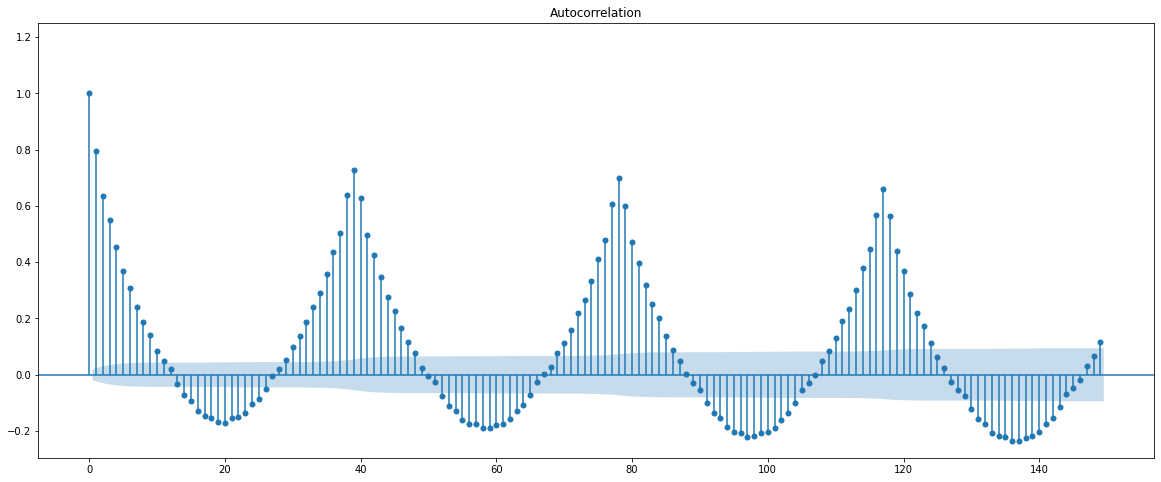

In [421]:
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(ts['VOLUME_fut'], ax = ax, lags = np.arange(150), auto_ylims = True)

# Preprocessing

## Remove strong outliers

In [422]:
std_num=4
for column in columns:
    mean = ts.iloc[train_indexes].mean(numeric_only=True)[column]
    std = ts.iloc[train_indexes].std(numeric_only=True)[column]
    up_border = mean + std_num * std
    down_border = mean - std_num * std
    ts[column] = ts[column].where(ts[column] <= up_border, up_border)
    ts[column] = ts[column].where(ts[column] >= down_border, down_border)

## Remove seasonality

### Intraday averaging

In [423]:
bins = 39
window_days = 5
ts[['VOLUME_fut_agg', 'VOLUME_etf_agg', 'VOLUME_opt_agg']] = np.NaN
all_hhmm = pd.unique(ts['hhmm'])

for i in range(0, ts.shape[0]-bins*(window_days+1)+1, 39):
    for hhmm in all_hhmm:
        hhmm_df = ts.iloc[i:bins*window_days+i].loc[ts['hhmm']==hhmm]
        for column in columns:
            vol_agg = hhmm_df.loc[:,column].mean()
            ts.iloc[i+bins*window_days:i+bins*(window_days+1)].loc[ts['hhmm']==hhmm, f'{column}_agg'] = vol_agg


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [424]:
ts.tail(200)

,VOLUME_fut,VOLUME_etf,hhmm,VOLUME_opt,VOLUME_fut_agg,VOLUME_etf_agg,VOLUME_opt_agg
Time,,,,,,,
2022-03-24 15:20:00,6339.000000,1.089825e+06,15:20,11035.00000,9317.0,1.411253e+06,15105.400000
2022-03-24 15:30:00,8899.000000,1.196821e+06,15:30,20136.00000,8569.6,1.661762e+06,16748.200000
2022-03-24 15:40:00,7851.000000,1.280128e+06,15:40,10581.00000,10021.0,1.738550e+06,15376.800000
2022-03-24 15:50:00,7249.000000,1.443316e+06,15:50,8555.00000,11292.2,2.051842e+06,17909.400000
2022-03-24 16:00:00,19173.000000,4.017140e+06,16:00,22950.00000,21689.0,4.078077e+06,24718.600000
2022-03-25 09:40:00,27536.000000,3.261773e+06,09:40,29356.00000,28126.4,3.604874e+06,23314.400000
2022-03-25 09:50:00,18452.000000,2.307753e+06,09:50,25781.00000,21124.6,2.909004e+06,22872.400000
2022-03-25 10:00:00,16297.000000,1.646699e+06,10:00,20290.00000,18301.4,2.554859e+06,18136.800000
2022-03-25 10:10:00,16216.000000,1.796899e+06,10:10,15951.00000,19246.4,2.282764e+06,18277.400000


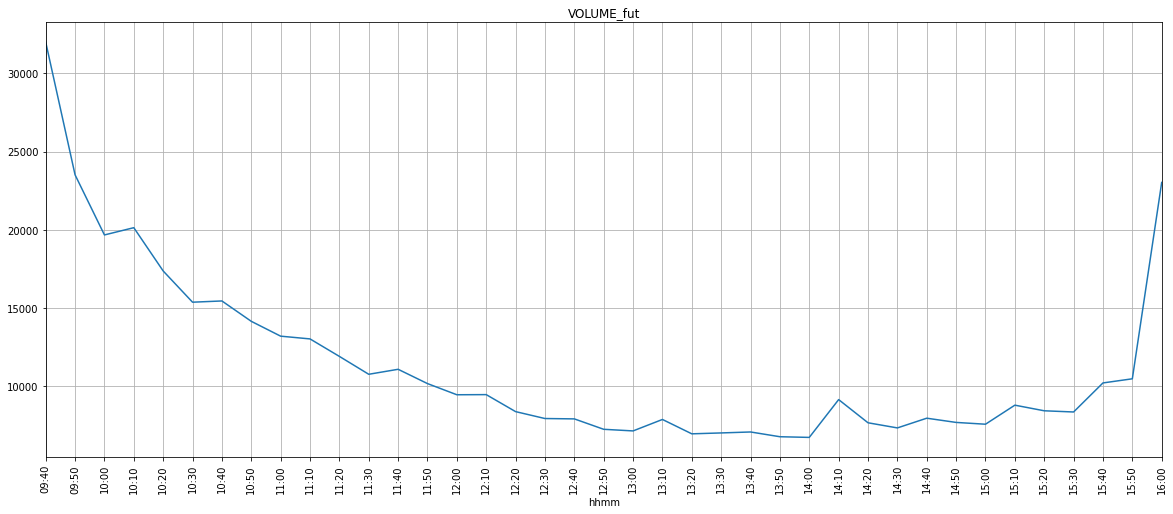

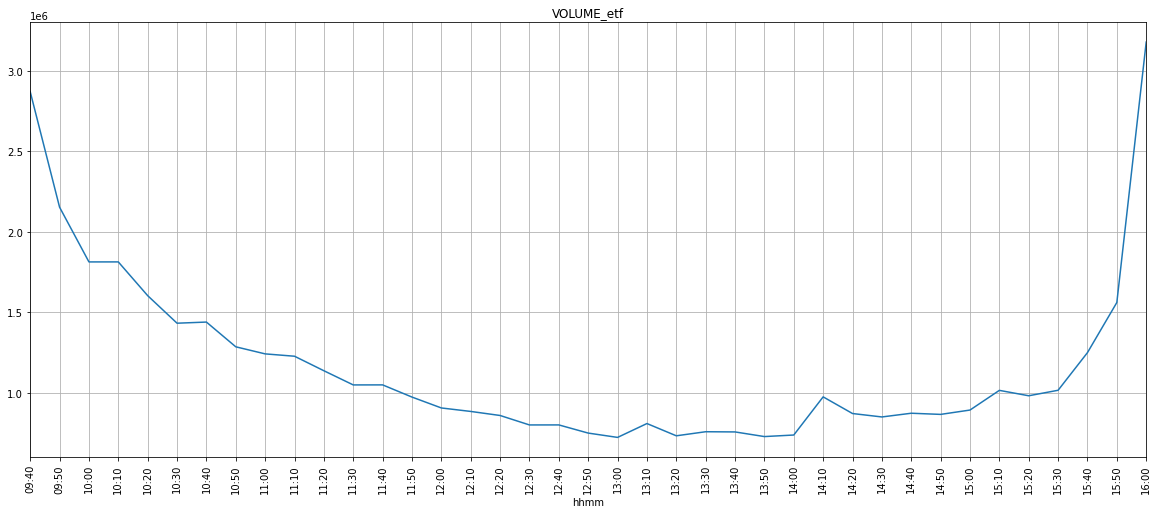

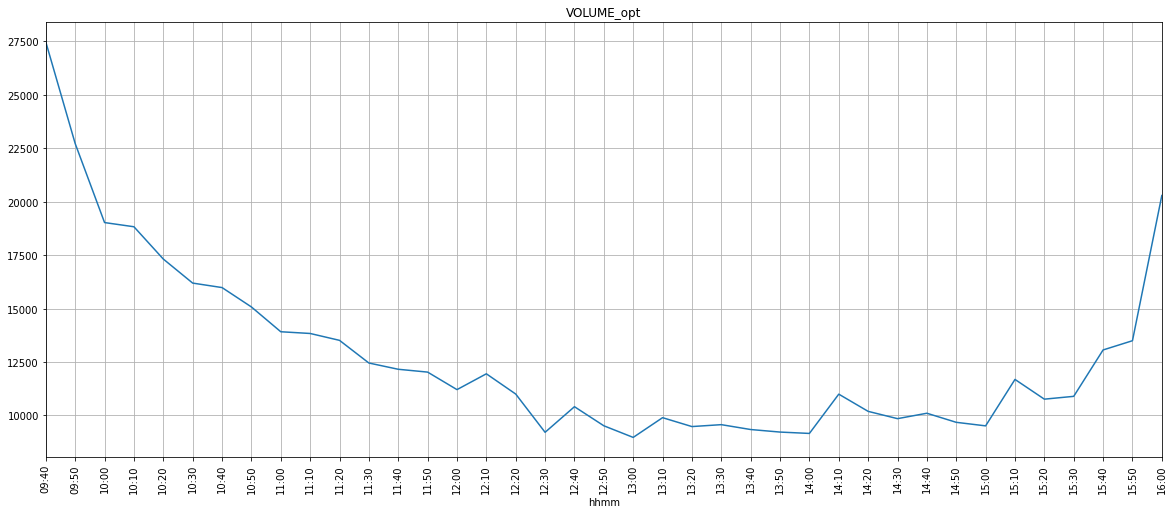

In [425]:
ts_agg = ts.groupby('hhmm').mean()

for column in columns:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax = ts_agg[column].plot(ax=ax, title=column)
    ax.set_xticks(list(range(ts_agg.shape[0])), list(ts_agg.index), rotation='vertical')
    ax.grid()
    ax.set_xlim(0, ts_agg.shape[0]-1)

### Calculate: VOLUME-INTRADAY_AVERAGE

In [426]:
# ts_unseason = ts.join(ts_agg, on='hhmm', rsuffix='_agg').copy(deep=True)
ts_unseason = ts.copy(deep=True)

for column in columns:
    ts_unseason[column] = ts_unseason[column] - ts_unseason[f'{column}_agg']

ts_unseason.dropna(inplace=True)
ts_unseason

,VOLUME_fut,VOLUME_etf,hhmm,VOLUME_opt,VOLUME_fut_agg,VOLUME_etf_agg,VOLUME_opt_agg
Time,,,,,,,
2021-04-09 09:40:00,342.000000,-442824.666422,09:40,21906.8,26746.0,2.561240e+06,18243.2
2021-04-09 09:50:00,5280.200000,-206985.400000,09:50,12349.0,16485.8,1.676073e+06,12455.0
2021-04-09 10:00:00,2525.400000,184714.400000,10:00,9211.0,13120.6,1.271584e+06,11341.0
2021-04-09 10:10:00,-2227.600000,-653298.200000,10:10,-315.8,16900.6,1.639199e+06,15383.8
2021-04-09 10:20:00,-3094.600000,-546429.800000,10:20,-2231.6,13527.6,1.398768e+06,13978.6
...,...,...,...,...,...,...,...
2022-03-31 15:20:00,1169.800000,35015.800000,15:20,6632.0,7702.2,1.248665e+06,12092.0
2022-03-31 15:30:00,3272.800000,-334929.000000,15:30,-467.8,9651.2,1.836575e+06,12990.8
2022-03-31 15:40:00,6770.000000,410511.200000,15:40,7161.4,9812.0,1.560381e+06,11673.6


# Features

## Partial autocorrelation

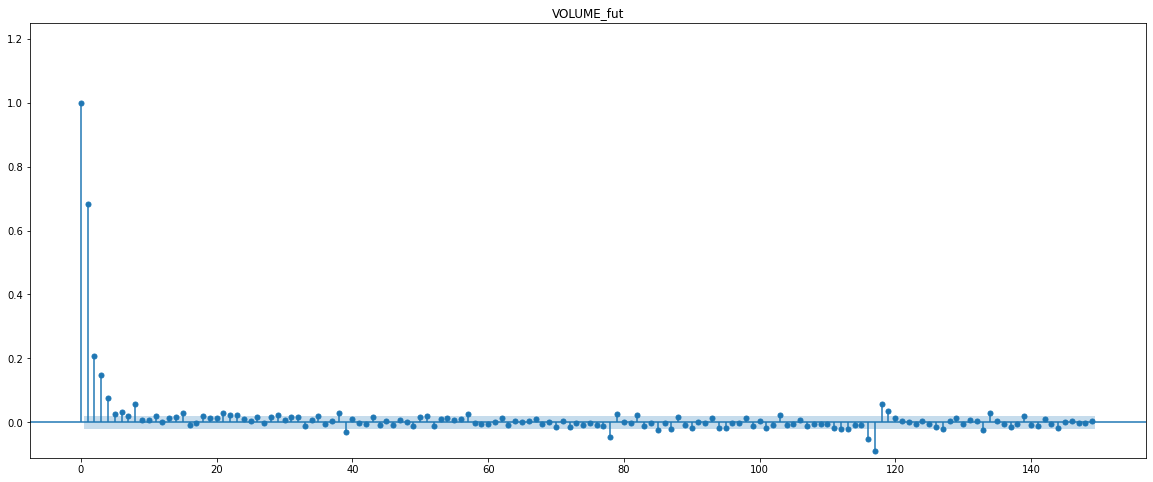

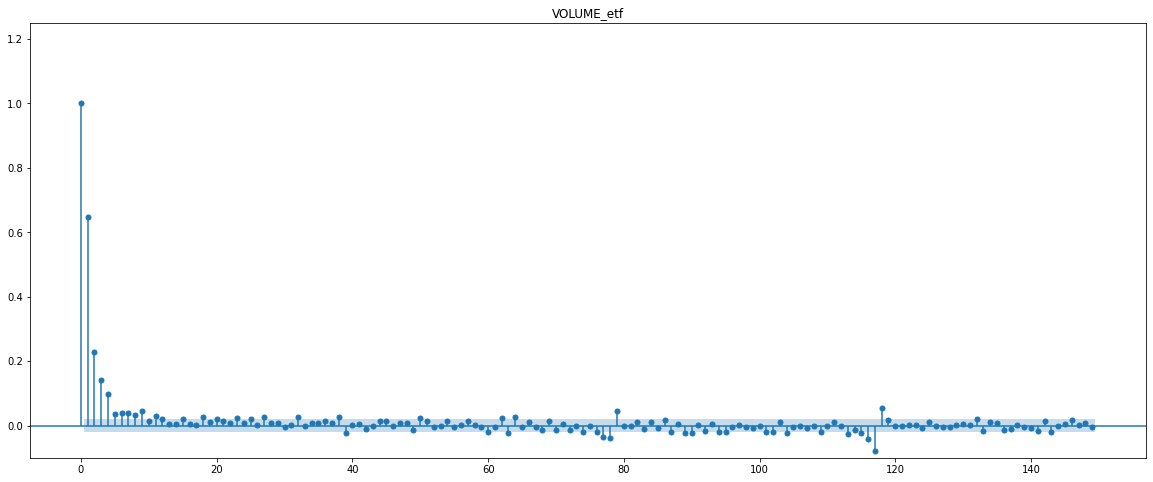

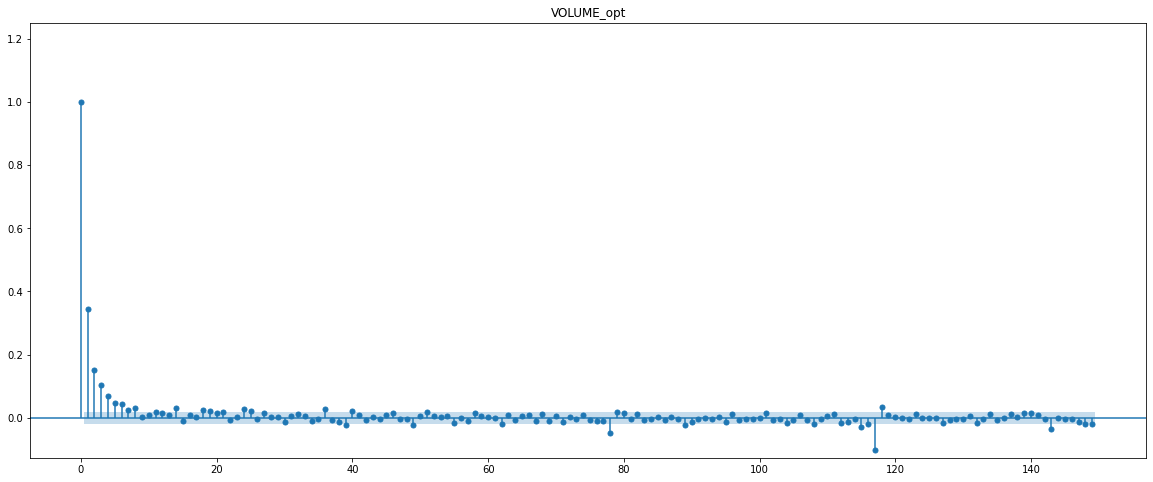

In [427]:
for column in columns:
    fig, ax = plt.subplots(figsize=(20, 8))
    plt_pacf = plot_pacf(ts_unseason[column], ax = ax, lags = np.arange(150), auto_ylims = True, method='ywm', title=column)

## Features

### Add lags

In [428]:
df = ts_unseason[columns+['hhmm', 'VOLUME_fut_agg']].copy(deep=True)

periods = [1, 2, 3, 4, 37, 38, 39, 40]
target = ['VOLUME_fut']
features_columns = []
for column in columns:
    for lag in periods:
        feature_col_name = f'{column}_lag_{lag}'
        df[feature_col_name] = df.shift(lag)[column]
        features_columns.append(feature_col_name)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_agg,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,VOLUME_fut_lag_37,VOLUME_fut_lag_38,VOLUME_fut_lag_39,VOLUME_fut_lag_40,VOLUME_etf_lag_1,VOLUME_etf_lag_2,VOLUME_etf_lag_3,VOLUME_etf_lag_4,VOLUME_etf_lag_37,VOLUME_etf_lag_38,VOLUME_etf_lag_39,VOLUME_etf_lag_40,VOLUME_opt_lag_1,VOLUME_opt_lag_2,VOLUME_opt_lag_3,VOLUME_opt_lag_4,VOLUME_opt_lag_37,VOLUME_opt_lag_38,VOLUME_opt_lag_39,VOLUME_opt_lag_40
0,3747.800000,-75862.600000,-7149.2,09:50,18200.2,-3265.2,5028.6,1256.0,3451.8,-2227.6,2525.4,5280.2,342.0,-415276.2,284113.6,122560.2,635935.4,-653298.200000,184714.400000,-2.069854e+05,-4.428247e+05,-12847.400000,9469.400000,2669.000000,17032.400000,-315.8,9211.0,12349.0,21906.80000
1,5478.000000,-120601.800000,-3361.6,10:00,14295.0,3747.8,-3265.2,5028.6,1256.0,-3094.6,-2227.6,2525.4,5280.2,-75862.6,-415276.2,284113.6,122560.2,-546429.800000,-653298.200000,1.847144e+05,-2.069854e+05,-7149.200000,-12847.400000,9469.400000,2669.000000,-2231.6,-315.8,9211.0,12349.00000
2,764.000000,-190031.000000,-8308.8,10:10,14630.0,5478.0,3747.8,-3265.2,5028.6,1444.2,-3094.6,-2227.6,2525.4,-120601.8,-75862.6,-415276.2,284113.6,-177244.800000,-546429.800000,-6.532982e+05,1.847144e+05,-3361.600000,-7149.200000,-12847.400000,9469.400000,3190.0,-2231.6,-315.8,9211.00000
3,-243.400000,-136099.400000,-9853.6,10:20,13436.4,764.0,5478.0,3747.8,-3265.2,3617.4,1444.2,-3094.6,-2227.6,-190031.0,-120601.8,-75862.6,-415276.2,-234620.800000,-177244.800000,-5.464298e+05,-6.532982e+05,-8308.800000,-3361.600000,-7149.200000,-12847.400000,-3586.8,3190.0,-2231.6,-315.80000
4,460.200000,-314220.800000,-4599.6,10:30,11346.8,-243.4,764.0,5478.0,3747.8,1868.4,3617.4,1444.2,-3094.6,-136099.4,-190031.0,-120601.8,-75862.6,-211108.200000,-234620.800000,-1.772448e+05,-5.464298e+05,-9853.600000,-8308.800000,-3361.600000,-7149.200000,3898.4,-3586.8,3190.0,-2231.60000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9627,1169.800000,35015.800000,6632.0,15:20,7702.2,2315.2,-625.0,439.4,1035.4,4298.8,6345.6,5283.0,1633.2,197685.4,-216883.6,-155559.8,41421.6,320661.000000,934255.600000,1.020760e+06,1.875754e+06,578.218532,402.600000,-3339.200000,-3875.200000,-1514.8,582.6,10424.0,44535.90734
9628,3272.800000,-334929.000000,-467.8,15:30,9651.2,1169.8,2315.2,-625.0,439.4,2701.8,4298.8,6345.6,5283.0,35015.8,197685.4,-216883.6,-155559.8,315711.800000,320661.000000,9.342556e+05,1.020760e+06,6632.000000,578.218532,402.600000,-3339.200000,1221.4,-1514.8,582.6,10424.00000
9629,6770.000000,410511.200000,7161.4,15:40,9812.0,3272.8,1169.8,2315.2,-625.0,1676.0,2701.8,4298.8,6345.6,-334929.0,35015.8,197685.4,-216883.6,-17243.332844,315711.800000,3.206610e+05,9.342556e+05,-467.800000,6632.000000,578.218532,402.600000,-8040.4,1221.4,-1514.8,582.60000
9630,4088.400000,853679.800000,2976.6,15:50,9672.6,6770.0,3272.8,1169.8,2315.2,-3161.0,1676.0,2701.8,4298.8,410511.2,-334929.0,35015.8,197685.4,-235694.066422,-17243.332844,3.157118e+05,3.206610e+05,7161.400000,-467.800000,6632.000000,578.218532,-15241.0,-8040.4,1221.4,-1514.80000


### Features importance

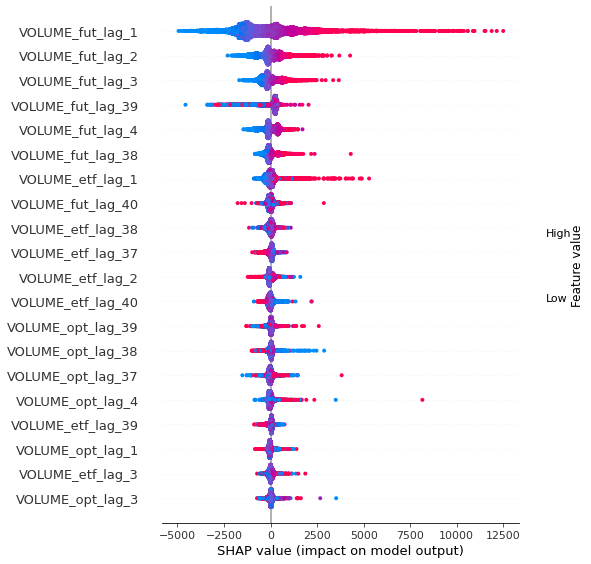

Index(['VOLUME_fut_lag_1', 'VOLUME_fut_lag_2', 'VOLUME_fut_lag_3',
       'VOLUME_fut_lag_39', 'VOLUME_fut_lag_4', 'VOLUME_fut_lag_38',
       'VOLUME_etf_lag_1', 'VOLUME_fut_lag_40', 'VOLUME_etf_lag_38',
       'VOLUME_etf_lag_37'],
      dtype='object')

In [429]:
cat = CatBoostRegressor(iterations=5000)
cat.fit(df[features_columns], df[target], verbose=0, plot=False)

explainer = shap.TreeExplainer(cat)
shap_values=explainer.shap_values(Pool(df[features_columns], df[target]))
shap.summary_plot(shap_values, df[features_columns])

top_features = pd.DataFrame(shap_values, columns=df[features_columns].columns).apply(lambda x: abs(x)).sum().sort_values(ascending=False)[:10].index
top_features

# Splitting

In [430]:
x_train, x_test, y_train, y_test = train_test_split(df[top_features], df[target], test_size=0.1, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)

In [431]:
x_train

,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_39,VOLUME_fut_lag_4,VOLUME_fut_lag_38,VOLUME_etf_lag_1,VOLUME_fut_lag_40,VOLUME_etf_lag_38,VOLUME_etf_lag_37
0,-3265.2,5028.6,1256.0,5280.2,3451.8,2525.4,-415276.2,342.0,184714.4,-653298.2
1,3747.8,-3265.2,5028.6,2525.4,1256.0,-2227.6,-75862.6,5280.2,-653298.2,-546429.8
2,5478.0,3747.8,-3265.2,-2227.6,5028.6,-3094.6,-120601.8,2525.4,-546429.8,-177244.8
3,764.0,5478.0,3747.8,-3094.6,-3265.2,1444.2,-190031.0,-2227.6,-177244.8,-234620.8
4,-243.4,764.0,5478.0,1444.2,3747.8,3617.4,-136099.4,-3094.6,-234620.8,-211108.2
...,...,...,...,...,...,...,...,...,...,...
7362,-2077.2,-1471.6,1344.8,20415.0,-4686.0,11998.0,-287588.0,17183.4,2109921.6,1781781.8
7363,-2453.6,-2077.2,-1471.6,11998.0,1344.8,15567.6,-314092.2,20415.0,1781781.8,1680223.4
7364,-1722.4,-2453.6,-2077.2,15567.6,-1471.6,13654.8,-153707.2,11998.0,1680223.4,1467806.4
7365,-341.6,-1722.4,-2453.6,13654.8,-2077.2,10765.4,470886.4,15567.6,1467806.4,1151018.8


In [432]:
y_train

,VOLUME_fut
0,3747.8
1,5478.0
2,764.0
3,-243.4
4,460.2
...,...
7362,-2453.6
7363,-1722.4
7364,-341.6
7365,14.8


In [433]:
x_train.index, x_val.index, x_test.index

(Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             7357, 7358, 7359, 7360, 7361, 7362, 7363, 7364, 7365, 7366],
            dtype='int64', length=7367),
 Int64Index([7367, 7368, 7369, 7370, 7371, 7372, 7373, 7374, 7375, 7376,
             ...
             8658, 8659, 8660, 8661, 8662, 8663, 8664, 8665, 8666, 8667],
            dtype='int64', length=1301),
 Int64Index([8668, 8669, 8670, 8671, 8672, 8673, 8674, 8675, 8676, 8677,
             ...
             9622, 9623, 9624, 9625, 9626, 9627, 9628, 9629, 9630, 9631],
            dtype='int64', length=964))

# Scaling

In [434]:
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = pd.DataFrame(data=scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
x_val = pd.DataFrame(data=scaler.transform(x_val), index=x_val.index, columns=x_val.columns)
x_test = pd.DataFrame(data=scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

# Training - Prediction

## XGBoost

In [435]:
xgb = XGBRegressor(nthread=4, n_estimators=300, max_depth=1, min_child_weight=6, learning_rate=0.08)
xgb.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_delta_step=0,
             max_depth=1, min_child_weight=6, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

StdDev: 6524.762780332292
MAE/StdDev 35.64108435397065
R2, MAE, MAPE:


(0.7420900845846492, 2325.496206434713, 0.19985420147643074)

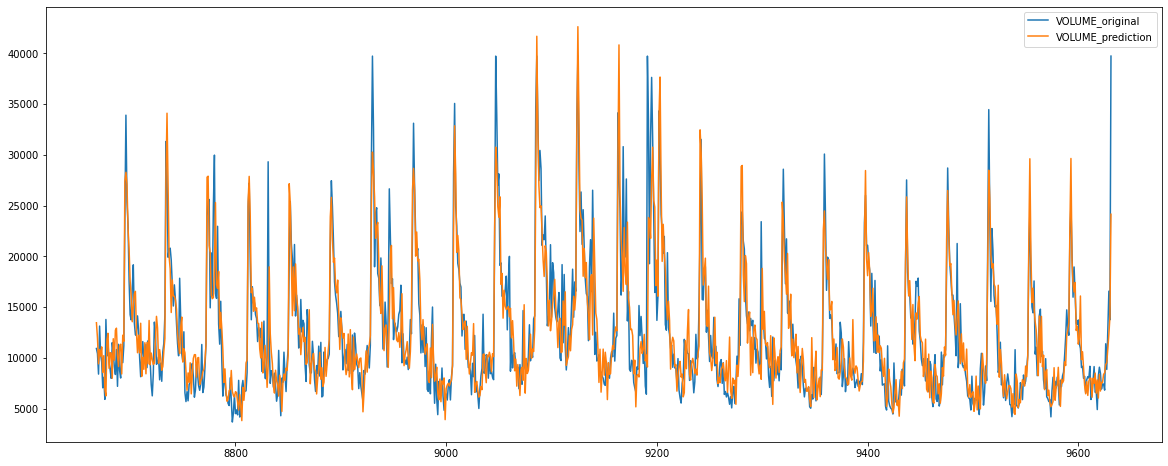

In [436]:
prediction_xgb = pd.DataFrame(xgb.predict(x_test), index=x_test.index, columns=['prediction'])

tdf_test = prediction_xgb.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut'] + tdf_test['VOLUME_fut_agg']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_xgb = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_xgb = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_xgb = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('StdDev:', std_orig)
print('MAE/StdDev', mae_xgb/std_orig*100)
print('R2, MAE, MAPE:')
(r2_xgb, mae_xgb, mape_xgb)

<AxesSubplot:>

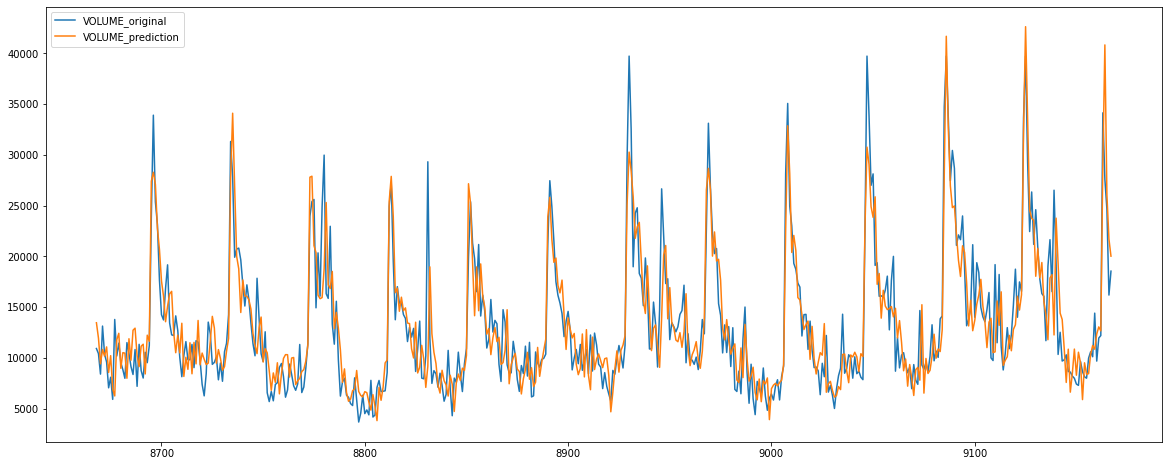

In [437]:
tdf_test.iloc[:500]['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test.iloc[:500]['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

In [438]:
# Optimization
# xgb = XGBRegressor(nthread=8)
# param_grid = {
#     'max_depth': [1],
#     'min_child_weight': [7],
#     'n_estimators': [250],
#     'learning_rate': [0.09]
# }
# # 100, 600, 50
# # 0.01, 0.02, 0.05, 0.1, 0.15
# gs = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     cv=5, 
#     n_jobs=8, 
#     scoring='neg_root_mean_squared_error',
#     verbose=2
# )

# fitted_model = gs.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=0)

In [439]:
# pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False)

## CatBoost

In [440]:
# cat = CatBoostRegressor(learning_rate=0.08, depth=4, l2_leaf_reg=1, iterations=1000)
# cat.fit(x_train, y_train, eval_set=Pool(x_val, y_val), use_best_model=True, verbose=0, plot=True)

param_grid = {'depth': [4], 'l2_leaf_reg': [1], 'learning_rate': [0.1], 'models_num': [10], 'early_stopping_rounds': [30]}
for idx, params in enumerate(ParameterGrid(param_grid)):
    models_num = params['models_num']
    cv_dataset = Pool(data=pd.concat([x_train, x_val]), label=pd.concat([y_train, y_val]))

    cat_params = {"iterations": 1000,
                  "depth": params['depth'],
                  "l2_leaf_reg": params['l2_leaf_reg'],
                  "learning_rate": params['learning_rate'],
                  "loss_function": "MAE",
                  "custom_metric": 'R2',
                  # "eval_metric": 'BalancedAccuracy',
                  "use_best_model": True,
                  "verbose": False}

    res = cv(cv_dataset,
             cat_params,
             fold_count=models_num,
             shuffle=False,
             early_stopping_rounds=params['early_stopping_rounds'],
             type='TimeSeries ',
             return_models=True,
             plot = False,
             logging_level='Silent')
    print(params)
    print(res[0]['test-MAE-mean'].min())

{'depth': 4, 'early_stopping_rounds': 30, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'models_num': 10}
2199.0421631967247


StdDev: 6524.762780332292
MAE/StdDev 34.963313966598896
R2, MAE, MAPE:
0.7367234204034833 2281.273296463367 0.19026918606361168


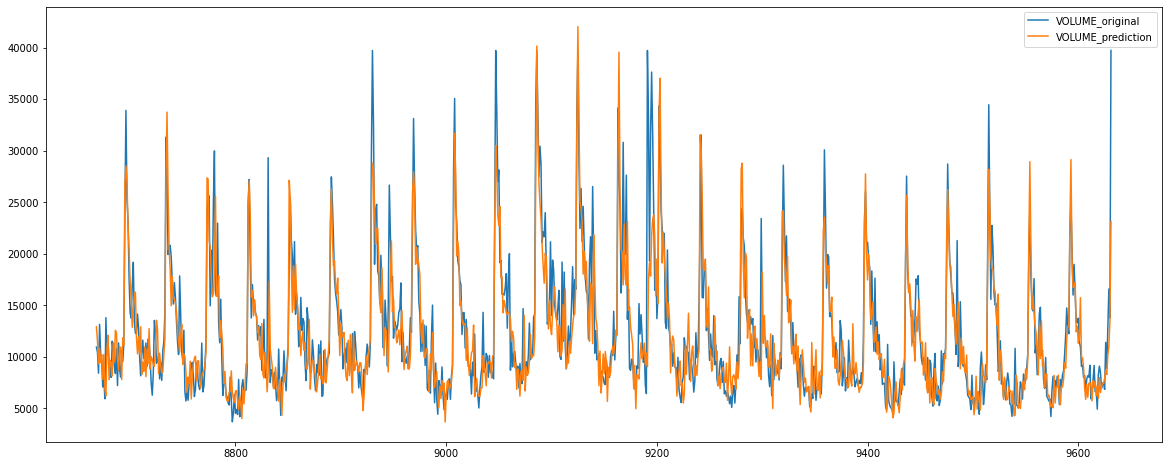

In [441]:
cat = sum_models(res[1], [1/models_num]*models_num)
    
prediction_cat = pd.DataFrame(cat.predict(x_test), index=x_test.index, columns=['prediction'])

tdf_test = prediction_cat.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut'] + tdf_test['VOLUME_fut_agg']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_cat = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_cat = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_cat = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('StdDev:', std_orig)
print('MAE/StdDev', mae_cat/std_orig*100)
print('R2, MAE, MAPE:')
print(r2_cat, mae_cat, mape_cat)

<AxesSubplot:>

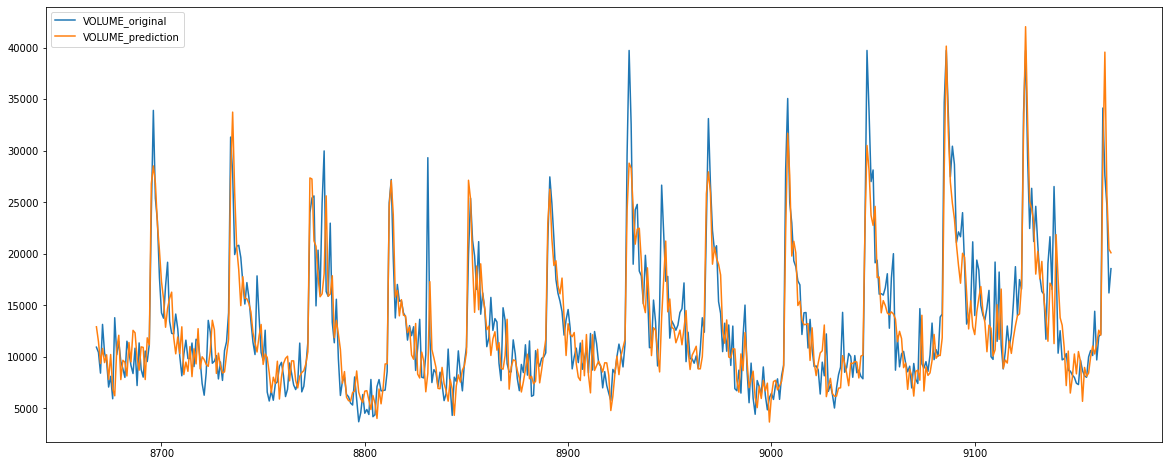

In [442]:
tdf_test.iloc[:500]['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test.iloc[:500]['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

In [443]:
# cat = CatBoostRegressor()
# grid = {'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
#         'depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#         'l2_leaf_reg': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# grid_search_result = cat.grid_search(grid, 
#                                        X=pd.concat([x_train, x_val]), 
#                                        y=pd.concat([y_train, y_val]),
#                                        cv=5,
#                                        shuffle=False,
#                                        verbose=False,
#                                        plot=True)

In [444]:
# pd.DataFrame(grid_search_result)

## DNN

In [445]:
class DNN(kt.HyperModel):
    def build(self, hp):
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Dropout

        model = Sequential()
        model.add(Dense(units=hp.Choice('units1', [4, 8, 16, 32]), activation = hp.Choice('activation1', ['relu', 'elu'])))
        # model.add(Dropout(0.1))     
        model.add(Dense(units=hp.Choice('units2', [4, 8, 16, 32]), activation = hp.Choice('activation2', ['relu', 'elu'])))
        # model.add(Dropout(0.1))     
        model.add(Dense(1))

        model.compile(loss = 'mean_squared_error', optimizer = 'RMSprop')
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args, 
            epochs=hp.Choice('epochs', [256, 512, 1024]), 
            batch_size=hp.Choice('batch_size', [16, 32, 64, 128]),
            shuffle=False, 
            verbose=0,
            **kwargs
        )

tuner = kt.RandomSearch(
    DNN(),
    objective='val_loss',
    max_trials = 150,
    directory='./dnn_checkpoints/',
    overwrite=False,
)
early_stopping = EarlyStopping(monitor='val_loss', patience=32, restore_best_weights=True)
tuner.search(x_train, y_train, validation_data=(x_val, y_val), callbacks=[early_stopping])

INFO:tensorflow:Reloading Oracle from existing project ./dnn_checkpoints/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./dnn_checkpoints/untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [446]:
tuner.results_summary()

Results summary
Results in ./dnn_checkpoints/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 32
activation1: relu
units2: 8
activation2: relu
epochs: 512
batch_size: 32
Score: 11722957.0
Trial summary
Hyperparameters:
units1: 32
activation1: relu
units2: 8
activation2: relu
epochs: 1024
batch_size: 128
Score: 11727233.0
Trial summary
Hyperparameters:
units1: 4
activation1: elu
units2: 8
activation2: relu
epochs: 1024
batch_size: 64
Score: 11736801.0
Trial summary
Hyperparameters:
units1: 8
activation1: elu
units2: 16
activation2: relu
epochs: 1024
batch_size: 32
Score: 11737388.0
Trial summary
Hyperparameters:
units1: 8
activation1: elu
units2: 32
activation2: relu
epochs: 512
batch_size: 32
Score: 11738243.0
Trial summary
Hyperparameters:
units1: 16
activation1: relu
units2: 8
activation2: relu
epochs: 512
batch_size: 16
Score: 11740103.0
Trial summary
Hyperparameters:
units1: 4
activation1: elu
units2: 32
activation2: relu
epochs: 1024
batch_size: 32
Sc

In [447]:
dnn_models = tuner.get_best_models(num_models=3)

StdDev: 6524.762780332292
MAE/StdDev 36.235059971303066
R2, MAE, MAPE:


(0.7328377381925726, 2364.2517064386675, 0.20476287300463492)

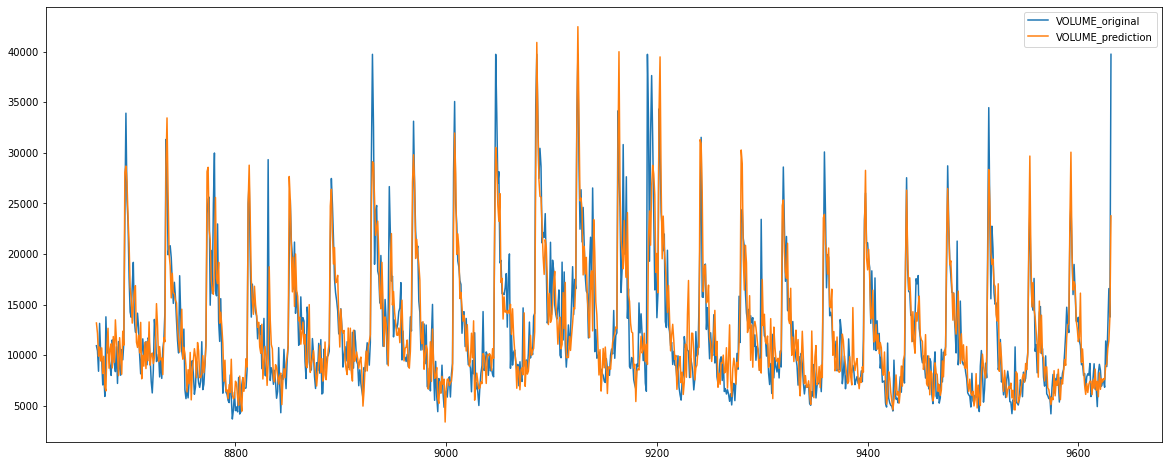

In [448]:
prediction_dnn = pd.DataFrame(pd.concat([pd.DataFrame(dnn.predict(x_test), index=x_test.index) for dnn in dnn_models], axis=1).mean(axis=1), columns=['prediction'])

tdf_test = prediction_dnn.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut'] + tdf_test['VOLUME_fut_agg']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_dnn = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_dnn = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_dnn = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('StdDev:', std_orig)
print('MAE/StdDev', mae_dnn/std_orig*100)
print('R2, MAE, MAPE:')
(r2_dnn, mae_dnn, mape_dnn)

<AxesSubplot:>

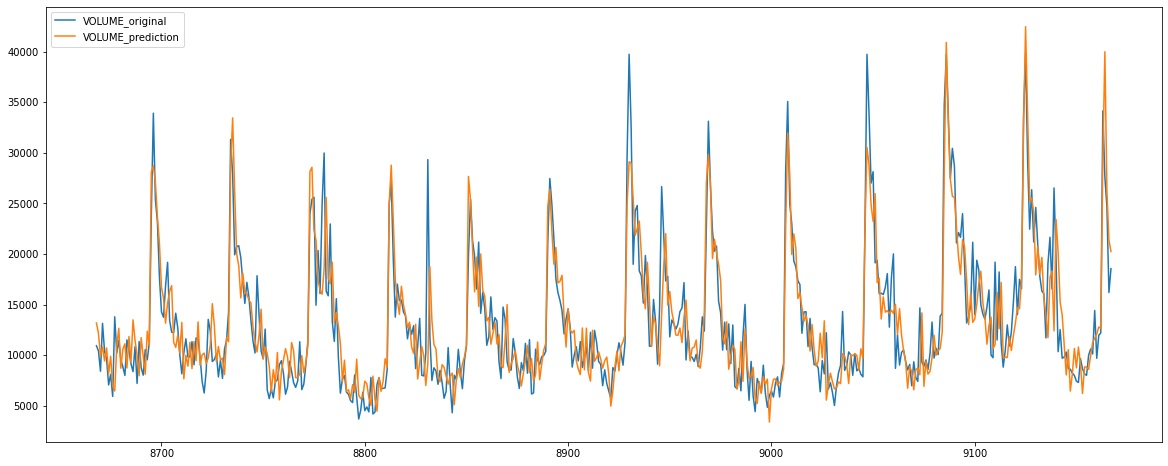

In [449]:
tdf_test.iloc[:500]['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test.iloc[:500]['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

## Deep Forest (Cascade Forest)

In [450]:
ccd = CascadeForestRegressor(n_jobs=8, n_estimators=2, n_trees=300, max_layers=15)
ccd.fit(pd.concat([x_train, x_val]).values, np.ravel(pd.concat([y_train, y_val]).values))

[2022-05-23 19:26:19.957] Start to fit the model:
[2022-05-23 19:26:19.957] Fitting cascade layer = 0 
[2022-05-23 19:26:24.267] layer = 0  | Val MSE = 10452825.61616 | Elapsed = 4.310 s
[2022-05-23 19:26:24.276] Fitting cascade layer = 1 
[2022-05-23 19:26:28.625] layer = 1  | Val MSE = 10507468.55371 | Elapsed = 4.349 s
[2022-05-23 19:26:28.625] Early stopping counter: 1 out of 2
[2022-05-23 19:26:28.633] Fitting cascade layer = 2 
[2022-05-23 19:26:33.029] layer = 2  | Val MSE = 10525195.70700 | Elapsed = 4.396 s
[2022-05-23 19:26:33.029] Early stopping counter: 2 out of 2
[2022-05-23 19:26:33.029] Handling early stopping
[2022-05-23 19:26:33.036] The optimal number of layers: 1


[2022-05-23 19:26:33.050] Start to evalute the model:
[2022-05-23 19:26:33.052] Evaluating cascade layer = 0 
StdDev: 6524.762780332292
MAE/StdDev 36.072203885364914
R2, MAE, MAPE:


(0.734570277529256, 2353.625733157869, 0.20209949912886874)

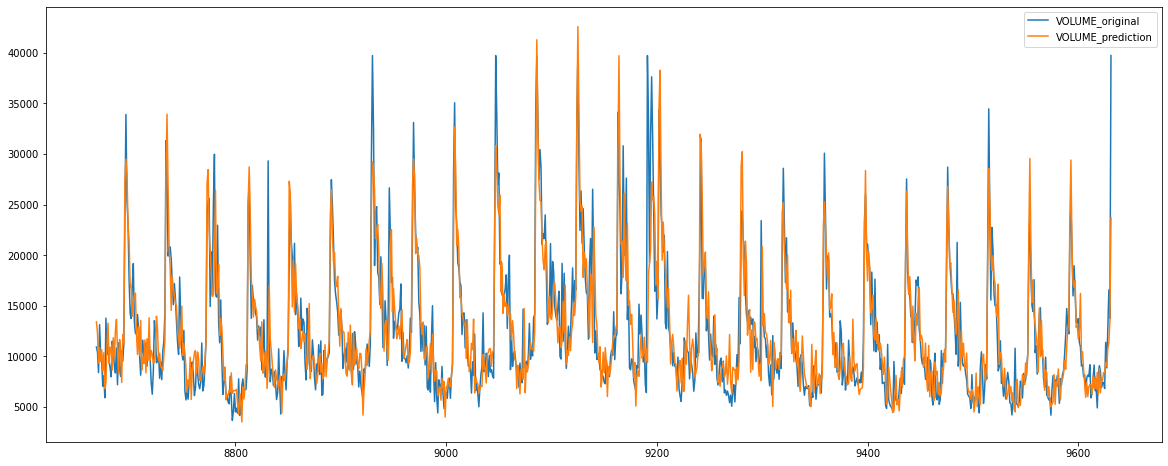

In [451]:
prediction_ccd = pd.DataFrame(ccd.predict(x_test), index=x_test.index, columns=['prediction'])

tdf_test = prediction_ccd.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut'] + tdf_test['VOLUME_fut_agg']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_ccd = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_ccd = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_ccd = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('StdDev:', std_orig)
print('MAE/StdDev', mae_ccd/std_orig*100)
print('R2, MAE, MAPE:')
(r2_ccd, mae_ccd, mape_ccd)

In [452]:
# Optimization
# res = {'params':[],
#       'metrics':[]}

# param_grid = {'n_estimators': [2], 'n_trees': [300], 'max_layers': [15]}
# for idx, params in enumerate(ParameterGrid(param_grid)):
#     print(params)
#     r2_ccd, mae_ccd, mape_ccd = 0, 0, 0
#     for j in range(1,11):
#         ccd = CascadeForestRegressor(n_jobs=8, n_estimators=params['n_estimators'], n_trees=params['n_trees'], max_layers=params['max_layers'], verbose=0)
#         ccd.fit(pd.concat([x_train, x_val]).values, np.ravel(pd.concat([y_train, y_val]).values))

#         prediction_ccd = pd.DataFrame(ccd.predict(x_test), index=x_test.index, columns=['prediction'])

#         tdf_test = prediction_ccd.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
#         tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
#         tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut'] + tdf_test['VOLUME_fut_agg']

#         r2_ccd += r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
#         mae_ccd += mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
#         mape_ccd += mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

#     r2_ccd /= 10
#     mae_ccd /=10
#     mape_ccd /= 10
#     print('R2, MAE, MAPE:')
#     print(r2_ccd, mae_ccd, mape_ccd)

## Totals

In [453]:
print('XGBoost:', r2_xgb, mae_xgb, mape_xgb)
print('CatBoost:', r2_cat, mae_cat, mape_cat)
print('DNN:', r2_dnn, mae_dnn, mape_dnn)
print('Cascade Forest:', r2_ccd, mae_ccd, mape_ccd)

XGBoost: 0.7420900845846492 2325.496206434713 0.19985420147643074
CatBoost: 0.7367234204034833 2281.273296463367 0.19026918606361168
DNN: 0.7328377381925726 2364.2517064386675 0.20476287300463492
Cascade Forest: 0.734570277529256 2353.625733157869 0.20209949912886874


# Ensemble model